# Evaluation: Moving average inference approach

In [62]:
import pandas as pd
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import lightgbm as lgb

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

from glob import glob
import os
import optuna
import joblib
import json
import pickle

## Load best parameters

In [63]:
agg = 'mean'
lookback_window = 60
run_date = '2022-06-02'

source_dir = f'../experiments/{agg}/'
study_name = f'{agg}-window-{lookback_window}-{run_date}'
storage_path = f'sqlite:///{save_dir}/{study_name}.db'

study = optuna.load_study(study_name=study_name, storage=storage_path)
res = study.trials_dataframe(attrs=('number', 'value', 'params', 'state', 'duration'))

In [64]:
# get current best params
best_params = {}
for key, value in res.sort_values('value', ascending=True).iloc[0].to_dict().items():
    if key.startswith('params_'):
        best_params[key.replace('params_', '')] = value
    elif key == 'value':
        print("Best (RMSE) Score: ", value)
        
fixed_params = {
    'tree_learner': 'data',
    'seed':11,
    'verbose': -1,
}
lgb_params = {}
lgb_params.update(fixed_params)
lgb_params.update(best_params)
lgb_params

Best (RMSE) Score:  6.132498123038543


{'boosting_type': 'goss',
 'objective': 'tweedie',
 'metric': 'rmse',
 'seed': 11,
 'verbose': -1,
 'learning_rate': 0.021815764111155836,
 'n_estimators': 653,
 'num_leaves': 502,
 'other_rate': 0.2543492124504017,
 'top_rate': 0.5785556168542206}

## Load data and filter

In [65]:
featname_map = {
    'dayofweek': 'Day',
    'hour': 'Hour',
    'number_of_lanes': 'Number of Lanes',
    'speed_limit_kph': 'Speed Limit',
    'pix_business_4x4' : 'Surrounding Commercial Pixels',
    'pix_residential_4x4': 'Surrounding Residential Pixels', 
    'pix_industrial_4x4' : 'Surrounding Industrial Pixels',
    'pix_institutional_4x4' : 'Surrounding Institutional Pixels',
    'elevation' : 'Elevation',
}

In [66]:
data_dir = f'../datasets/inference'

# load data
test = pd.read_csv(f'{data_dir}/{agg}-window-{lookback_window}-test-{run_date}.csv')
retrain = pd.read_csv(f'{data_dir}/{agg}-window-{lookback_window}-retrain-{run_date}.csv')

In [ ]:
print("Retrain shape: ", retrain.shape)
print("Test shape: ", test.shape)

In [67]:
# usecols for ML
discrete_num_cols = ['number_of_lanes', 'speed_limit_kph',]
building_types = ['residential', 'business', 'industrial', 'institutional']
pixel_size = '4x4'
landuse_cols = [f'pix_{type_}_{pixel_size}' for type_ in building_types]
num_cols = landuse_cols + discrete_num_cols + ['elevation']

# cat cols
cat_cols = ['hour', 'dayofweek']
features = sorted(cat_cols + num_cols) # sort for reference in feature order
cat_cols_index = [index for (index, col) in enumerate(features) if col in cat_cols]
cat_cols_index

In [68]:
results_dir = "../results"
column_labels_dir = "column-labels"
save_dir = os.path.join(results_dir, column_labels_dir)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# write feature order to file as reference
with open(f'{save_dir}/{study_name}-columnrefs.pickle', 'wb') as f:
    pickle.dump(features, f)

In [70]:
# use recomputed_speed
X_train, y_train = retrain[features], retrain['agg_speed']
X_test, y_test = test[features], test['agg_speed']

In [69]:
retrain = retrain.rename(columns=featname_map)
test = test.rename(columns=featname_map)

In [71]:
# # for damian's plotting
# retrain.to_csv(f'{data_dir}/full-retrain-data-{date}.csv', index=False)
# test.to_csv(f'{data_dir}/full-test-data-{date}.csv', index=False)

In [72]:
%%time
model = lgb.LGBMRegressor(**lgb_params)
model.fit(X_train, y_train, categorical_feature=cat_cols_index)

Using categorical_feature in Dataset.


CPU times: user 35min 24s, sys: 2min 37s, total: 38min 2s
Wall time: 1min 25s


LGBMRegressor(boosting_type='goss', learning_rate=0.021815764111155836,
              metric='rmse', n_estimators=653, num_leaves=502,
              objective='tweedie', other_rate=0.2543492124504017, seed=11,
              top_rate=0.5785556168542206, verbose=-1)

In [73]:
# save model
save_dir = os.path.join(results_dir, 'models')
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
model.booster_.save_model(f'{save_dir}/{study_name}-model.txt')

In [75]:
# save y-yhat
y_pred = model.predict(X_test)
y_true = y_test.values

y_yhat = {
    'true': list(y_true),
    'pred' : list(y_pred)
}

save_dir = os.path.join(results_dir, 'predictions')
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
with open(f'{save_dir}/{study_name}-preds.json', 'w') as f:
    json.dump(y_yhat, f)

In [76]:
def get_score(y_true, y_preds):
    return r2_score(y_true, y_preds)
def rmse(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

print("R2: ", get_score(y_true, y_pred))
print("RMSE: ", rmse(y_true, y_pred))
print("MAE: ", mean_absolute_error(y_true, y_pred))
print("MAPE: ", mean_absolute_percentage_error(y_true, y_pred))

R2:  0.7342744037424562
RMSE:  5.90839264624477
MAE:  4.493506122909862
MAPE:  285523949791884.75


In [77]:
def plot_lgb_yyhat(y_true, y_pred, title, ax):
    temp = pd.DataFrame()
    temp['True Value'] = y_true
    temp['Predicted Value'] = y_pred
    temp.plot(kind='scatter', x='True Value', y='Predicted Value',
              ax=ax, alpha=0.1, c='green', marker='*')
    
    ax.set_title(title, fontsize=18)
    ax.set_xlabel('True Value', fontsize=12)
    ax.set_ylabel('Predicted Value', fontsize=12)

    ax.set_ylim([i for i in ax.get_xlim()])
    
    # diagonal perfect prediction reference
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, c='black',
                   label='Perfect Prediction')
    ax.legend(fontsize=15, loc='upper left')
    
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    # set spines lw
    ax.spines['left'].set_linewidth(3)
    ax.spines['bottom'].set_linewidth(3)
    
    # tick params
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    
    r2 = get_score(y_true, y_pred)
    ax.annotate(f"R2={r2:.2f}", size=15, xy=(55, 0))
    
    rmse_score = rmse(y_true, y_pred)
    ax.annotate(f"RMSE={rmse_score:.2f}", size=15, xy=(55, 5))
    return ax

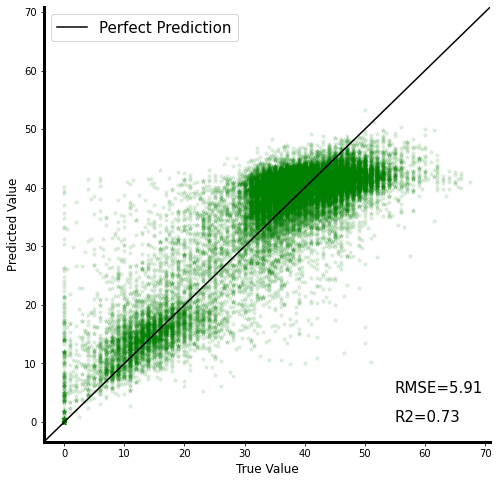

In [78]:
figures_dir = '../figures'
save_dir = os.path.join(figures_dir, 'performance')
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
fig, ax = plt.subplots(figsize=(8, 8))
plot_lgb_yyhat(y_true, y_pred, title=None, ax=ax)
    
fig.savefig(f'{save_dir}/{study_name}-yyhat.jpg', dpi=600, bbox_inches='tight')
plt.show()

## SHAP Evaluation

In [79]:
%%time
print("Test set shape: ", X_test.shape)

# perfrom shap on test set
explainer = shap.TreeExplainer(model)

Test set shape:  (30357, 8)
CPU times: user 12.2 s, sys: 829 ms, total: 13 s
Wall time: 13 s


In [80]:
%%time
explanation = explainer(X_test)

CPU times: user 1h 44min 40s, sys: 4.19 s, total: 1h 44min 44s
Wall time: 3min 58s


In [81]:
%%time
# shap_values = explainer.shap_valus(X_test.sample(n=1000, replace=False)) # change to X_test
shap_values = explainer.shap_values(X_test) 

CPU times: user 1h 44min 10s, sys: 3.75 s, total: 1h 44min 14s
Wall time: 4min 4s


In [82]:
save_dir = os.path.join(results_dir, 'shap-vals')
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

with open(f'{save_dir}/{study_name}-shap-vals.pickle', 'wb') as f:
    pickle.dump(shap_values, f)

### Global Interpretations

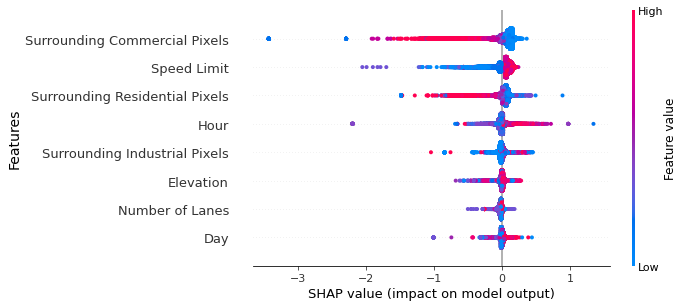

CPU times: user 7.53 s, sys: 184 ms, total: 7.71 s
Wall time: 7.51 s


In [83]:
%%time
# plots beeswarm
sum_fig = shap.summary_plot(shap_values, X_test, show=False)

# plt.title('Summary Plot of SHAP Importance', fontsize=18)
plt.ylabel('Features', fontsize=14)

## in case column names are not good for plotting use a name mapper
# ax = plt.gca()
# new_labels = [featname_map[i.get_text()] for i in ax.get_yticklabels()]
# ax.set_yticklabels(new_labels)

plt.gcf().axes[-1].set_aspect(100)
plt.gcf().axes[-1].set_box_aspect(100)

figures_dir = '../figures'
save_dir = os.path.join(figures_dir, 'shap')
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

plt.savefig(f'{save_dir}/{study_name}-beeswarm.jpg', dpi=600, bbox_inches='tight')
plt.show()

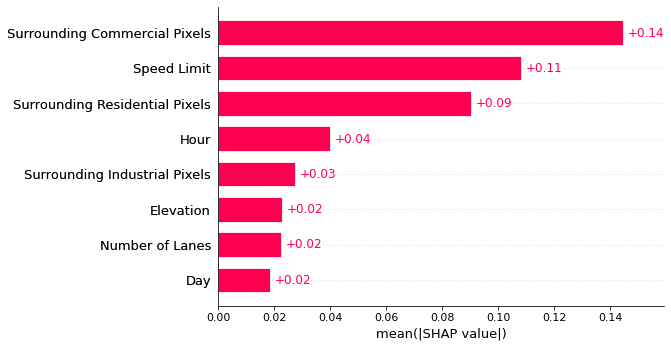

In [84]:
fi_fig = shap.plots.bar(explanation, max_display=X_test.shape[1], show=False)
# plt.title('Average SHAP Importance', fontsize=12)
# plt.ylabel('Features', fontsize=14)


## in case column names are not good for plotting use a name mapper
# ax = plt.gca()
# new_labels = [featname_map[i.get_text()] for i in ax.get_yticklabels()]
# ax.set_yticklabels(new_labels)

## black bars
# for bar in ax.containers:
#     # plt.setp sets a property on all elements of the container
#     plt.setp(bar, color="black")



# Hide the right and top spines
ax.spines['left'].set_visible(False)

plt.savefig(f'{save_dir}/{study_name}-fi.jpg', dpi=600, bbox_inches='tight')
plt.show()

### Local Interpretations

#### Waterfall and forceplots plots

In [85]:
# get a low error prediction for a predicted vehicle moving average speed
speed = 0 # speed of interest
speed_indexes = np.where(y_true==speed)[0]
speed_errors = (np.abs(y_true - y_pred))[y_true==speed]
sorted_indexed_errors = sorted(list(zip(speed_indexes, speed_errors)), key=lambda x:x[1])

# index of best predicted zero speed
print("Absolute Error: ", sorted_indexed_errors[0][1])
index = sorted_indexed_errors[0][0]

Absolute Error:  0.0012885913847446263


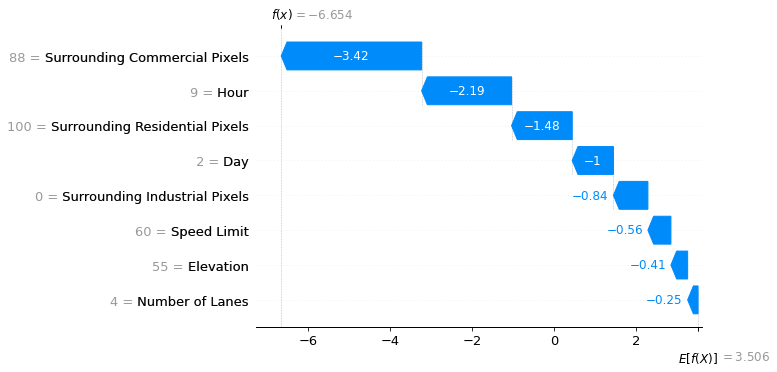

<Figure size 432x288 with 0 Axes>

In [86]:
# bar plots are used since waterfall source code has some bugs: pl.ioff() plt not found
# wf_fig = shap.waterfall_plot(explanation[index], show=False)
wf_fig = shap.waterfall_plot(explanation[index])

plt.savefig(f'{save_dir}/{study_name}-waterfall-speed-{speed}.jpg', 
            dpi=600, bbox_inches='tight')
plt.show()

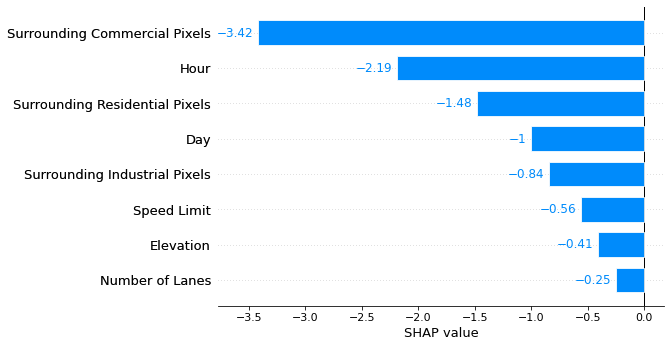

In [87]:
bar_fig = shap.plots.bar(explanation[index], show=False)

plt.savefig(f'{save_dir}/{study_name}-localbar-speed-{speed}.jpg', dpi=600, bbox_inches='tight')
plt.show()

In [88]:
def force_plot(explainer, shap_values, X_test, j, speed):
    shap.initjs() 
    p = shap.force_plot(
        explainer.expected_value, 
        shap_values[j], X_test.iloc[[j]], 
        show=False
    )
    plt.savefig(f'{save_dir}/{study_name}-force-speed-{speed}.jpg', dpi=600, bbox_inches='tight')
    plt.close()
    return(p)

In [89]:
force_plot(explainer, shap_values, X_test, j=index, speed=speed)

In [90]:
# get a low error prediction for a predicted vehicle moving average speed
speed = 10 # speed of interest
speed_indexes = np.where(y_true==speed)[0]
speed_errors = (np.abs(y_true - y_pred))[y_true==speed]
sorted_indexed_errors = sorted(list(zip(speed_indexes, speed_errors)), key=lambda x:x[1])

# index of best predicted zero speed
print("Absolute Error: ", sorted_indexed_errors[0][1])
index = sorted_indexed_errors[0][0]

Absolute Error:  0.07731496276992722


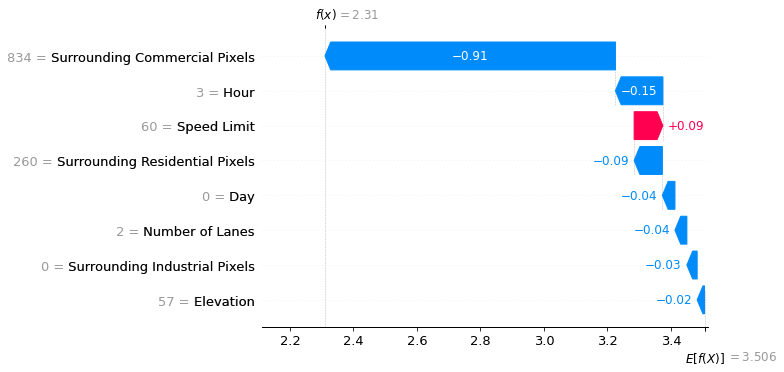

<Figure size 432x288 with 0 Axes>

In [91]:
# bar plots are used since waterfall source code has some bugs: pl.ioff() plt not found
# wf_fig = shap.waterfall_plot(explanation[index], show=False)
wf_fig = shap.waterfall_plot(explanation[index])

plt.savefig(f'{save_dir}/{study_name}-waterfall-speed-{speed}.jpg', 
            dpi=600, bbox_inches='tight')
plt.show()

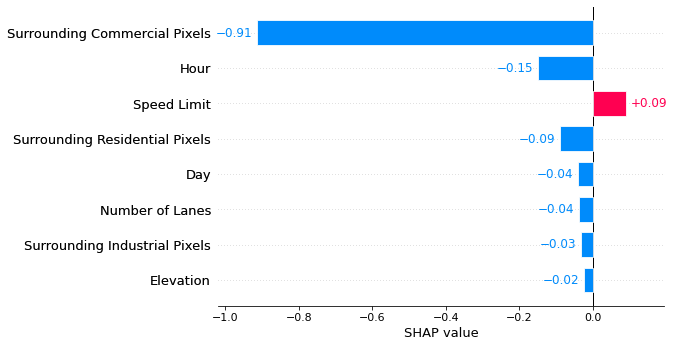

In [92]:
bar_fig = shap.plots.bar(explanation[index], show=False)

plt.savefig(f'{save_dir}/{study_name}-localbar-speed-{speed}.jpg', dpi=600, bbox_inches='tight')
plt.show()

In [93]:
force_plot(explainer, shap_values, X_test, j=index, speed=speed)

Absolute Error:  0.018379269759975614


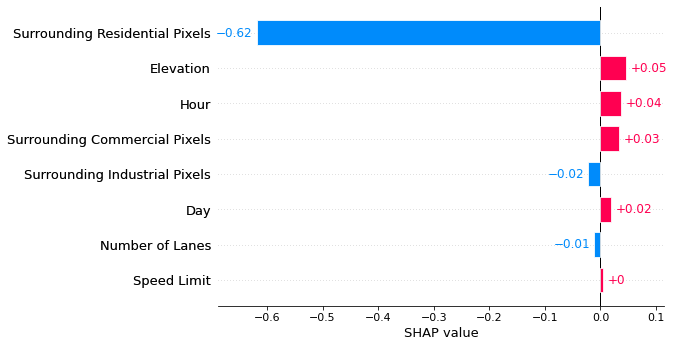

In [94]:
# get a low error prediction for a predicted vehicle moving average speed
speed = 20 # speed of interest
speed_indexes = np.where(y_true==speed)[0]
speed_errors = (np.abs(y_true - y_pred))[y_true==speed]
sorted_indexed_errors = sorted(list(zip(speed_indexes, speed_errors)), key=lambda x:x[1])

# index of best predicted zero speed
print("Absolute Error: ", sorted_indexed_errors[0][1])
index = sorted_indexed_errors[0][0]

bar_fig = shap.plots.bar(explanation[index], show=False)

plt.savefig(f'{save_dir}/{study_name}-localbar-speed-{speed}.jpg', dpi=600, bbox_inches='tight')
plt.show()

Absolute Error:  0.07363088104347781


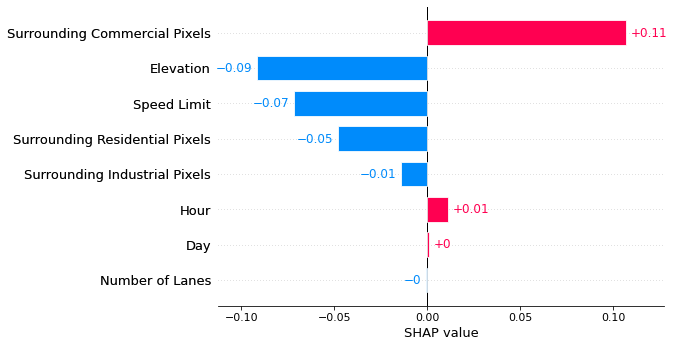

In [95]:
# get a low error prediction for a predicted vehicle moving average speed
speed = 30 # speed of interest
speed_indexes = np.where(y_true==speed)[0]
speed_errors = (np.abs(y_true - y_pred))[y_true==speed]
sorted_indexed_errors = sorted(list(zip(speed_indexes, speed_errors)), key=lambda x:x[1])

# index of best predicted zero speed
print("Absolute Error: ", sorted_indexed_errors[0][1])
index = sorted_indexed_errors[0][0]

bar_fig = shap.plots.bar(explanation[index], show=False)

plt.savefig(f'{save_dir}/{study_name}-localbar-speed-{speed}.jpg', dpi=600, bbox_inches='tight')
plt.show()

Absolute Error:  0.0032466796090275807


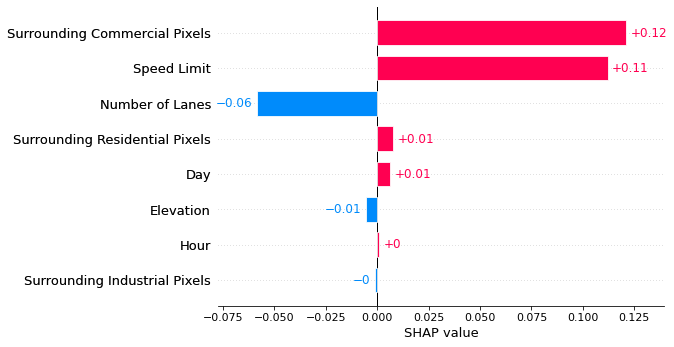

In [96]:
# get a low error prediction for a predicted vehicle moving average speed
speed = 40 # speed of interest
speed_indexes = np.where(y_true==speed)[0]
speed_errors = (np.abs(y_true - y_pred))[y_true==speed]
sorted_indexed_errors = sorted(list(zip(speed_indexes, speed_errors)), key=lambda x:x[1])

# index of best predicted zero speed
print("Absolute Error: ", sorted_indexed_errors[0][1])
index = sorted_indexed_errors[0][0]

bar_fig = shap.plots.bar(explanation[index], show=False)

plt.savefig(f'{save_dir}/{study_name}-localbar-speed-{speed}.jpg', dpi=600, bbox_inches='tight')
plt.show()

Absolute Error:  0.36257855211302115


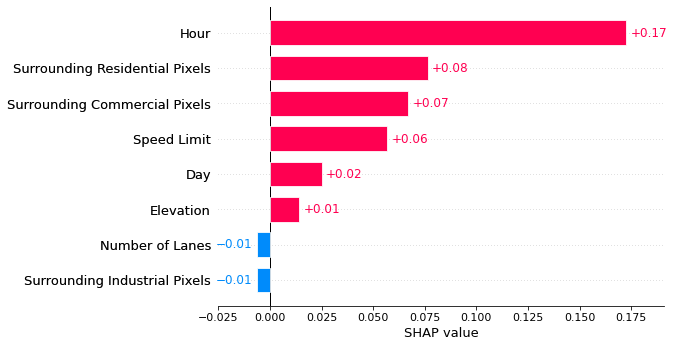

In [97]:
# get a low error prediction for a predicted vehicle moving average speed
speed = 50 # speed of interest
speed_indexes = np.where(y_true==speed)[0]
speed_errors = (np.abs(y_true - y_pred))[y_true==speed]
sorted_indexed_errors = sorted(list(zip(speed_indexes, speed_errors)), key=lambda x:x[1])

# index of best predicted zero speed
print("Absolute Error: ", sorted_indexed_errors[0][1])
index = sorted_indexed_errors[0][0]

bar_fig = shap.plots.bar(explanation[index], show=False)

plt.savefig(f'{save_dir}/{study_name}-localbar-speed-{speed}.jpg', dpi=600, bbox_inches='tight')
plt.show()